# Sentiment Analysis - Natural Language Processing

### Import necessary libraries

In [1]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
#import gensim
import re


import unicodedata
tokenizer = ToktokTokenizer()
#nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


### Reading the Cleaned Dataset

In [2]:
# Read the file
df2 = pd.read_csv('cleaned_dataset.csv')

In [3]:
# Sample observations
df2.head(3)

,customer,product,review_text,rating_class,year,clean_text,tokens
0,A6VPK7X53QNAQ,B0000CC64W,If I had to choose only one product to take ca...,good,2009,choose one product take care face rest life wo...,"['choose', 'one', 'product', 'take', 'care', '..."
1,A3CHMHGSJSQ02J,B0000CC64W,Makes my skin lovely and smooth As a woman nea...,good,2013,make skin lovely smooth woman near need help g...,"['make', 'skin', 'lovely', 'smooth', 'woman', ..."
2,A1V1EP514B5H7Y,B0000CC64W,Works well at a reasonable price I've used thi...,good,2011,work well reasonable price use regenerating se...,"['work', 'well', 'reasonable', 'price', 'use',..."


# Natural Language Processing

## 1. Feature Engineering and Selection

Machine Learning models take numerical values as input. Our dataset is a list of sentences, so in order for our algorithm to extract patterns from the data, we first need to find a way to represent it in a way that our algorithm can understand, i.e. as a list of numbers. 

We will implement CounterVectorizer, TF-IDF, Hash Vectorizer, Word2Vec, adding most common words into the stopwords list, SMOTE, PCA, and Truncated SVD techniques into our models in the following sections as a part of feature engineering and selection.

## 2. Data Preprocessing

**Separating Response Variable and Feature**

In [4]:
df2['rating_class'] = df2['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [5]:
# Splitting the Data Set into Train and Test Sets
X = df2['clean_text']
y = df2['rating_class']

**Splitting Dataset into Train and Test Set**

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data. 

In [6]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(18381,)
Test Set Shape		:(6128,)


## 3. Selecting the Right Evaluation Metric

As the data imbalance is emphasized above, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

**Confusion Matrix Plot Function**

A first step is to understand the types of errors our model makes, and which kind of errors are least desirable. A good way to visualize this information is using a Confusion Matrix, which compares the predictions our model makes with the true label. Ideally, the matrix would be a diagonal line from top left to bottom right (our predictions match the truth perfectly).

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.summer):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [9]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## 4. Modelling 

This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by females who bought beauty products in Amazon e-commerce system.  We used Python’s Scikit Learn libraries to solve our problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. 

Since the ratings of the reviews were not distributed normally, we decided to decrease rating classes from 5 to 2 by merging Rating 1-2 as ‘Bad’ and Rating 4-5 as 'Good' while keeping Rating 3 is out of our model. 

In this section, we will try combinations of different vectorizers and models to get the prediction scores for sentiment analysis. 

## 4.1 CountVectorizer Bag of Words

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:

- **tokenizing** strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.

- **counting** the occurrences of tokens in each document.

- **normalizing** and weighting with diminishing importance tokens that occur in the majority of samples / documents.

In this scheme, features and samples are defined as follows:

- each **individual token occurrence frequency** (normalized or not) is treated as a feature.

- the vector of all the token frequencies for a given **document** is considered a multivariate sample.
A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

**"CountVectorizer"** implements both tokenization and occurrence counting in a single class. 

In [10]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [11]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 21808


In [12]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [13]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,___________________________________________________________i,_____________________________________________i,________________________________________product,_____________________addendum,aa,aaa,aaaaahhhhhhh,aaaah,aaaahhhh,aaack,...,zone,zoo,zoolander,zoom,zoomlash,zwill,zwilling,zync,zz,zzzzap
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Creating a function for applying different algorithms**

In [14]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

### 4.1.1 Logistic Regression with CountVectorizer

In [15]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.9229260093841383


**Classification Report**

In [16]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.50      0.73      0.59       514
           1       0.97      0.93      0.95      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.74      0.83      0.77      6128
weighted avg       0.93      0.92      0.92      6128



**Confusion Matrix**

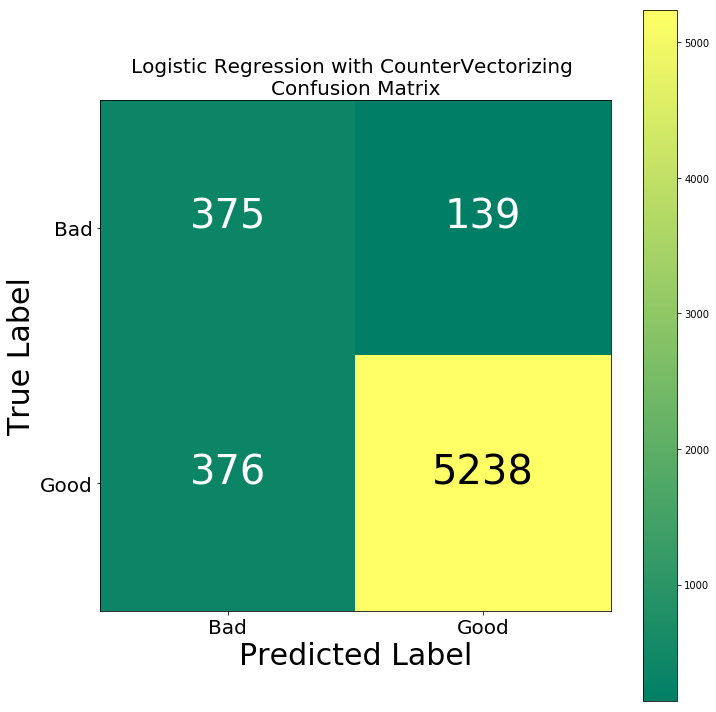

In [17]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

### 4.1.2 Random Forest with CountVectorizer

In [18]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.879188119188214


**Classification Report**

In [19]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       1.00      0.02      0.03       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

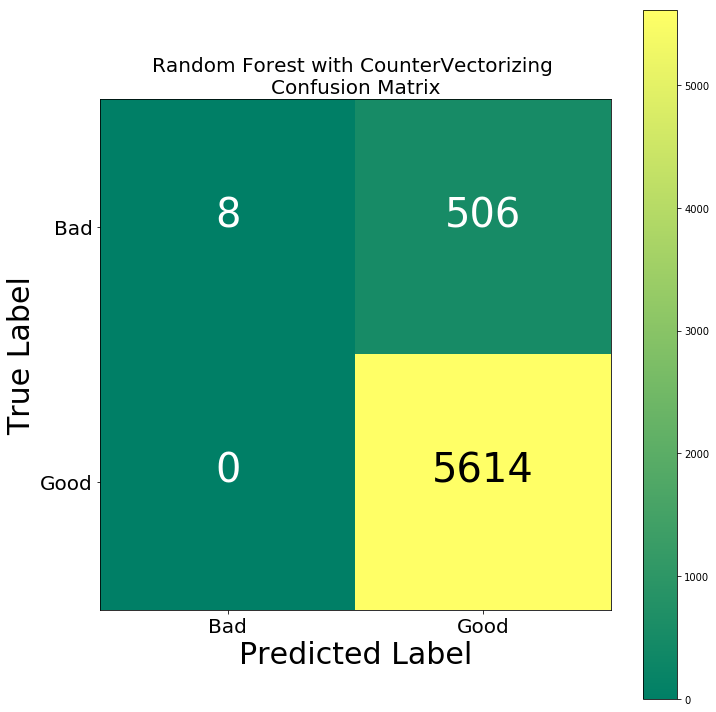

In [20]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

### 4.1.3 Naive Bayes with CountVectorizer 

In [21]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.9244233192137602


**Classification Report**

In [22]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.69      0.38      0.49       514
           1       0.95      0.98      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.82      0.68      0.73      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

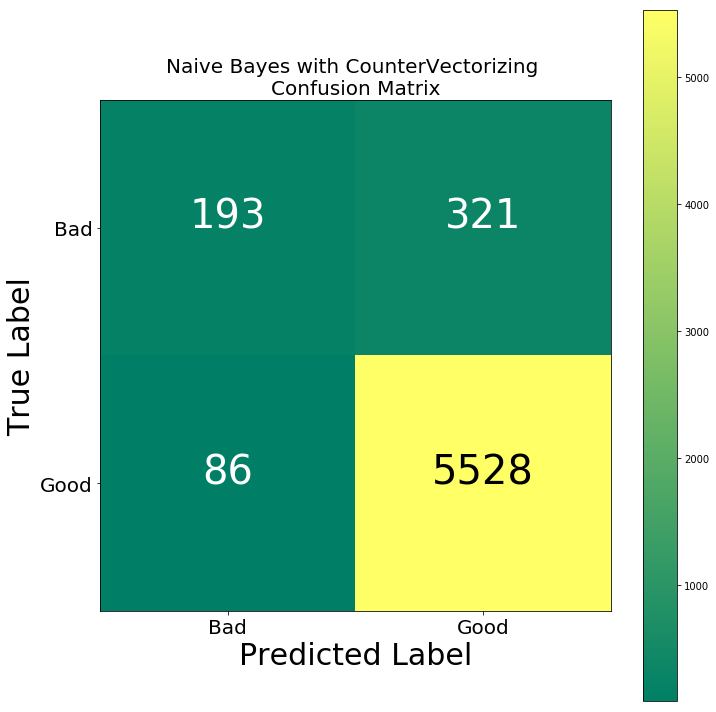

In [23]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

### 4.1.4 XGBoost with CountVectorizer

In [24]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.8941529692558983


**Classification Report**

In [25]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.79      0.10      0.18       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.86      0.55      0.57      6128
weighted avg       0.91      0.92      0.89      6128



**Confusion Matrix**

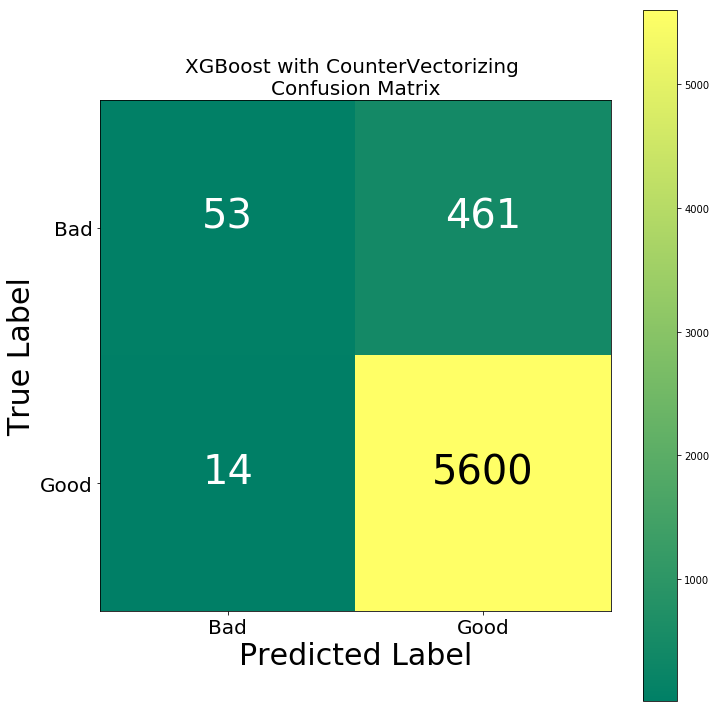

In [26]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

### 4.1.5 CatBoost with CountVectorizer

In [27]:
# Call the modeling function for CatBoost with countvectorizer and print f1 score
modeling(CatBoostClassifier(iterations=1000, learning_rate=0.8, 
                            depth=2, loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.3018452	total: 135ms	remaining: 2m 15s
1:	learn: 0.2685634	total: 213ms	remaining: 1m 46s
2:	learn: 0.2567093	total: 289ms	remaining: 1m 36s
3:	learn: 0.2496921	total: 379ms	remaining: 1m 34s
4:	learn: 0.2428042	total: 456ms	remaining: 1m 30s
5:	learn: 0.2399127	total: 514ms	remaining: 1m 25s
6:	learn: 0.2365168	total: 573ms	remaining: 1m 21s
7:	learn: 0.2304531	total: 631ms	remaining: 1m 18s
8:	learn: 0.2263375	total: 687ms	remaining: 1m 15s
9:	learn: 0.2232063	total: 746ms	remaining: 1m 13s
10:	learn: 0.2208724	total: 805ms	remaining: 1m 12s
11:	learn: 0.2182095	total: 865ms	remaining: 1m 11s
12:	learn: 0.2177957	total: 921ms	remaining: 1m 9s
13:	learn: 0.2140510	total: 980ms	remaining: 1m 9s
14:	learn: 0.2132447	total: 1.04s	remaining: 1m 8s
15:	learn: 0.2070136	total: 1.1s	remaining: 1m 7s
16:	learn: 0.2048960	total: 1.16s	remaining: 1m 6s
17:	learn: 0.2035962	total: 1.22s	remaining: 1m 6s
18:	learn: 0.2024776	total: 1.28s	remaining: 1m 6s
19:	learn: 0.2000411	total: 1.

162:	learn: 0.1450226	total: 9.57s	remaining: 49.1s
163:	learn: 0.1449345	total: 9.63s	remaining: 49.1s
164:	learn: 0.1447518	total: 9.68s	remaining: 49s
165:	learn: 0.1445748	total: 9.73s	remaining: 48.9s
166:	learn: 0.1441647	total: 9.8s	remaining: 48.9s
167:	learn: 0.1440285	total: 9.85s	remaining: 48.8s
168:	learn: 0.1439242	total: 9.9s	remaining: 48.7s
169:	learn: 0.1438712	total: 9.95s	remaining: 48.6s
170:	learn: 0.1437127	total: 10s	remaining: 48.5s
171:	learn: 0.1431013	total: 10.1s	remaining: 48.5s
172:	learn: 0.1430072	total: 10.1s	remaining: 48.5s
173:	learn: 0.1429380	total: 10.2s	remaining: 48.4s
174:	learn: 0.1428834	total: 10.2s	remaining: 48.3s
175:	learn: 0.1428444	total: 10.3s	remaining: 48.2s
176:	learn: 0.1427940	total: 10.4s	remaining: 48.2s
177:	learn: 0.1426761	total: 10.4s	remaining: 48.1s
178:	learn: 0.1426092	total: 10.5s	remaining: 48s
179:	learn: 0.1425771	total: 10.5s	remaining: 47.9s
180:	learn: 0.1417348	total: 10.6s	remaining: 47.9s
181:	learn: 0.141590

322:	learn: 0.1270139	total: 18.2s	remaining: 38.1s
323:	learn: 0.1270023	total: 18.3s	remaining: 38.1s
324:	learn: 0.1269376	total: 18.3s	remaining: 38s
325:	learn: 0.1269337	total: 18.4s	remaining: 38s
326:	learn: 0.1269175	total: 18.4s	remaining: 37.9s
327:	learn: 0.1269129	total: 18.5s	remaining: 37.8s
328:	learn: 0.1268715	total: 18.5s	remaining: 37.8s
329:	learn: 0.1268150	total: 18.6s	remaining: 37.7s
330:	learn: 0.1267338	total: 18.6s	remaining: 37.6s
331:	learn: 0.1266957	total: 18.7s	remaining: 37.6s
332:	learn: 0.1266473	total: 18.7s	remaining: 37.5s
333:	learn: 0.1266306	total: 18.8s	remaining: 37.4s
334:	learn: 0.1266151	total: 18.8s	remaining: 37.4s
335:	learn: 0.1265484	total: 18.9s	remaining: 37.3s
336:	learn: 0.1264291	total: 18.9s	remaining: 37.3s
337:	learn: 0.1264272	total: 19s	remaining: 37.2s
338:	learn: 0.1264226	total: 19s	remaining: 37.1s
339:	learn: 0.1263755	total: 19.1s	remaining: 37.1s
340:	learn: 0.1263742	total: 19.2s	remaining: 37s
341:	learn: 0.1263596	

483:	learn: 0.1158270	total: 26.8s	remaining: 28.5s
484:	learn: 0.1158258	total: 26.8s	remaining: 28.5s
485:	learn: 0.1158076	total: 26.9s	remaining: 28.4s
486:	learn: 0.1157854	total: 26.9s	remaining: 28.4s
487:	learn: 0.1157845	total: 27s	remaining: 28.3s
488:	learn: 0.1157807	total: 27s	remaining: 28.3s
489:	learn: 0.1157511	total: 27.1s	remaining: 28.2s
490:	learn: 0.1157083	total: 27.1s	remaining: 28.1s
491:	learn: 0.1156981	total: 27.2s	remaining: 28.1s
492:	learn: 0.1156851	total: 27.3s	remaining: 28s
493:	learn: 0.1156222	total: 27.3s	remaining: 28s
494:	learn: 0.1155990	total: 27.4s	remaining: 27.9s
495:	learn: 0.1155911	total: 27.4s	remaining: 27.9s
496:	learn: 0.1155018	total: 27.5s	remaining: 27.8s
497:	learn: 0.1154791	total: 27.5s	remaining: 27.7s
498:	learn: 0.1154664	total: 27.6s	remaining: 27.7s
499:	learn: 0.1154661	total: 27.6s	remaining: 27.6s
500:	learn: 0.1153885	total: 27.7s	remaining: 27.6s
501:	learn: 0.1153881	total: 27.7s	remaining: 27.5s
502:	learn: 0.115333

646:	learn: 0.1068162	total: 35.4s	remaining: 19.3s
647:	learn: 0.1068150	total: 35.5s	remaining: 19.3s
648:	learn: 0.1067902	total: 35.5s	remaining: 19.2s
649:	learn: 0.1067703	total: 35.6s	remaining: 19.2s
650:	learn: 0.1066172	total: 35.6s	remaining: 19.1s
651:	learn: 0.1065311	total: 35.7s	remaining: 19s
652:	learn: 0.1063084	total: 35.7s	remaining: 19s
653:	learn: 0.1062969	total: 35.8s	remaining: 18.9s
654:	learn: 0.1062487	total: 35.8s	remaining: 18.9s
655:	learn: 0.1061891	total: 35.9s	remaining: 18.8s
656:	learn: 0.1061670	total: 35.9s	remaining: 18.8s
657:	learn: 0.1061669	total: 36s	remaining: 18.7s
658:	learn: 0.1061664	total: 36s	remaining: 18.7s
659:	learn: 0.1061646	total: 36.1s	remaining: 18.6s
660:	learn: 0.1061623	total: 36.1s	remaining: 18.5s
661:	learn: 0.1061439	total: 36.2s	remaining: 18.5s
662:	learn: 0.1060867	total: 36.3s	remaining: 18.4s
663:	learn: 0.1060755	total: 36.3s	remaining: 18.4s
664:	learn: 0.1060575	total: 36.4s	remaining: 18.3s
665:	learn: 0.106003

808:	learn: 0.1010125	total: 43.9s	remaining: 10.4s
809:	learn: 0.1010084	total: 44s	remaining: 10.3s
810:	learn: 0.1010079	total: 44s	remaining: 10.3s
811:	learn: 0.1010052	total: 44.1s	remaining: 10.2s
812:	learn: 0.1009704	total: 44.1s	remaining: 10.1s
813:	learn: 0.1009702	total: 44.2s	remaining: 10.1s
814:	learn: 0.1009089	total: 44.2s	remaining: 10s
815:	learn: 0.1008862	total: 44.3s	remaining: 9.98s
816:	learn: 0.1008852	total: 44.3s	remaining: 9.93s
817:	learn: 0.1008826	total: 44.4s	remaining: 9.87s
818:	learn: 0.1008816	total: 44.4s	remaining: 9.82s
819:	learn: 0.1008791	total: 44.5s	remaining: 9.76s
820:	learn: 0.1008747	total: 44.5s	remaining: 9.71s
821:	learn: 0.1008646	total: 44.6s	remaining: 9.65s
822:	learn: 0.1008645	total: 44.6s	remaining: 9.6s
823:	learn: 0.1008546	total: 44.7s	remaining: 9.54s
824:	learn: 0.1008546	total: 44.7s	remaining: 9.49s
825:	learn: 0.1008326	total: 44.8s	remaining: 9.43s
826:	learn: 0.1007975	total: 44.8s	remaining: 9.38s
827:	learn: 0.10079

968:	learn: 0.0976405	total: 52.2s	remaining: 1.67s
969:	learn: 0.0976399	total: 52.3s	remaining: 1.62s
970:	learn: 0.0976047	total: 52.3s	remaining: 1.56s
971:	learn: 0.0976043	total: 52.4s	remaining: 1.51s
972:	learn: 0.0976043	total: 52.4s	remaining: 1.46s
973:	learn: 0.0976011	total: 52.5s	remaining: 1.4s
974:	learn: 0.0975985	total: 52.5s	remaining: 1.35s
975:	learn: 0.0975972	total: 52.6s	remaining: 1.29s
976:	learn: 0.0975961	total: 52.6s	remaining: 1.24s
977:	learn: 0.0975811	total: 52.7s	remaining: 1.19s
978:	learn: 0.0975773	total: 52.8s	remaining: 1.13s
979:	learn: 0.0975656	total: 52.8s	remaining: 1.08s
980:	learn: 0.0975515	total: 52.9s	remaining: 1.02s
981:	learn: 0.0975514	total: 52.9s	remaining: 970ms
982:	learn: 0.0975252	total: 53s	remaining: 916ms
983:	learn: 0.0974701	total: 53s	remaining: 862ms
984:	learn: 0.0974621	total: 53.1s	remaining: 808ms
985:	learn: 0.0974561	total: 53.1s	remaining: 754ms
986:	learn: 0.0974521	total: 53.2s	remaining: 700ms
987:	learn: 0.097

**Classification Report**

In [28]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.61      0.39      0.47       514
           1       0.95      0.98      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.78      0.68      0.72      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

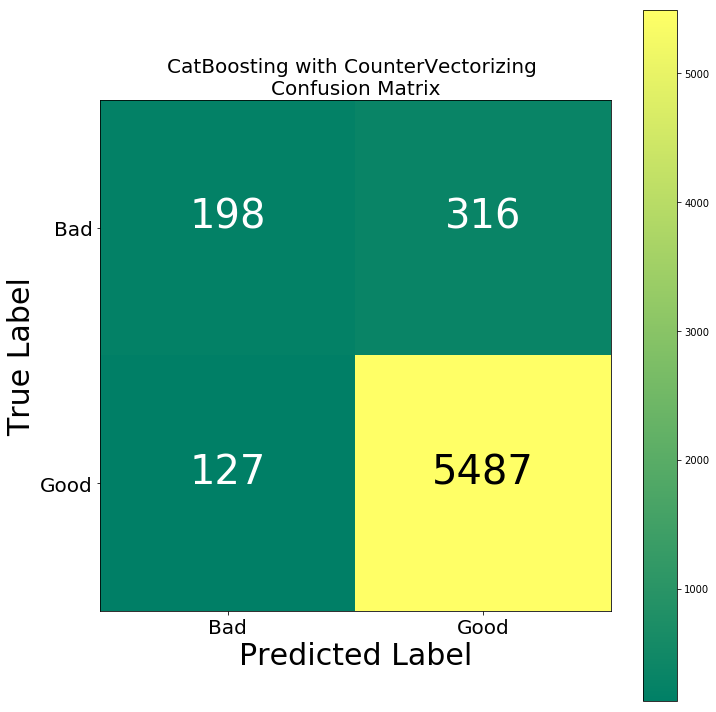

In [29]:
# Print confusion matrix for CatBoost with countVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting")

### 4.1.6 Comparison of Models with CountVectorizer

**Functions for Algorithms Comparison**

In [35]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [31]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

**Function for f1 Score Plotting**

In [32]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

**Algorithms Comparison with CountVectorizer**

In [36]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [39]:
df_tv2

precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.915960 bad       0.499334  0.729572  0.592885   
                                  good      0.974149  0.933025  0.953143   
                                  average   0.934323  0.915960  0.922926   
           Random Forest 0.917428 bad       1.000000  0.015564  0.030651   
                                  good      0.917320  1.000000  0.956877   
                                  average   0.924255  0.917428  0.879188   
           Naive Bayes   0.933584 bad       0.691756  0.375486  0.486759   
                                  good      0.945119  0.984681  0.964494   
                                  average   0.923867  0.933584  0.924423   
           XGBoost       0.922487 bad       0.791045  0.103113  0.182444   
                                  good      0.923940  0.997506  0.959315   
                                  average   0.912793  0.922487  0.894153   
           CatBoost      0.927709 bad       0.609231  0.385214  0.471990   
                                  good      0.945545  0.977378  0.961198   
                                  average   0.917336  0.927709  0.920165   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.915960 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917428 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.933584 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.922487 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.927709 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 Score - Models with CountVectorizer**

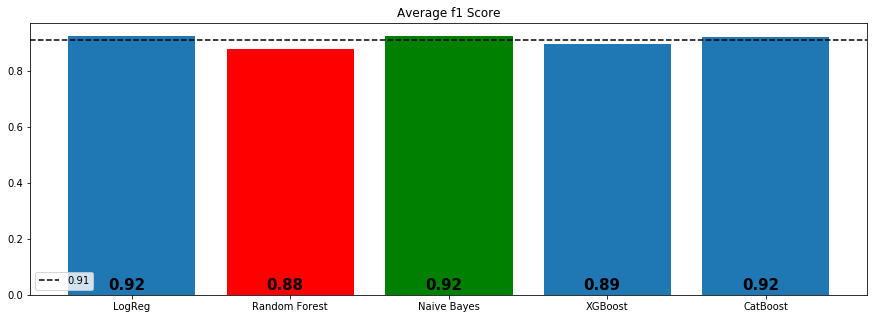

In [41]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

## 4.2 TF-IDF Bag of Words 

In order to help our model focus more on meaningful words, we can use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.

In [42]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

### 4.2.1 Logistic Regression with TF-IDF

In [43]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.8949011705776584


**Classification Report**

In [44]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.39      0.84      0.53       514
           1       0.98      0.88      0.93      5614

   micro avg       0.88      0.88      0.88      6128
   macro avg       0.69      0.86      0.73      6128
weighted avg       0.93      0.88      0.89      6128



**Confusion Matrix**

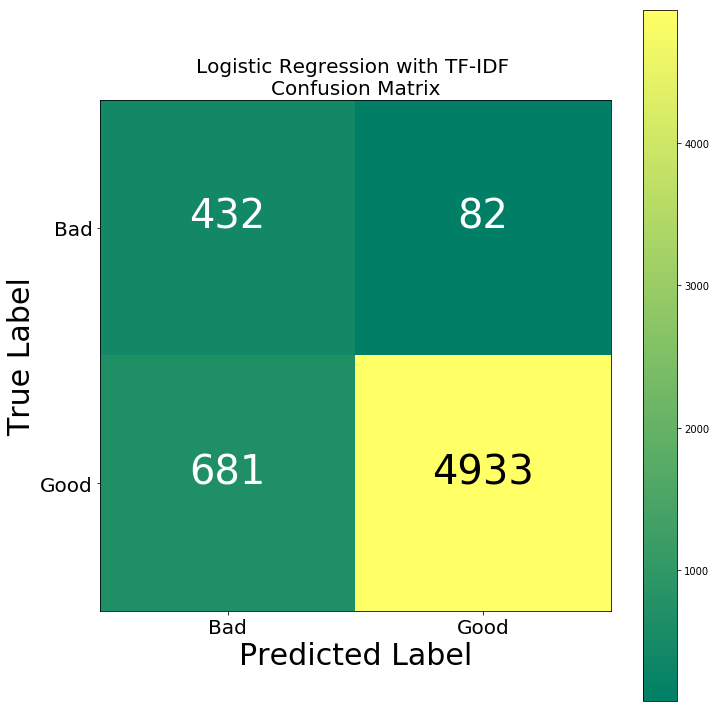

In [45]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

### 4.2.2 Random Forest with TF-IDF

In [46]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.8787963670186205


**Classification Report**

In [47]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

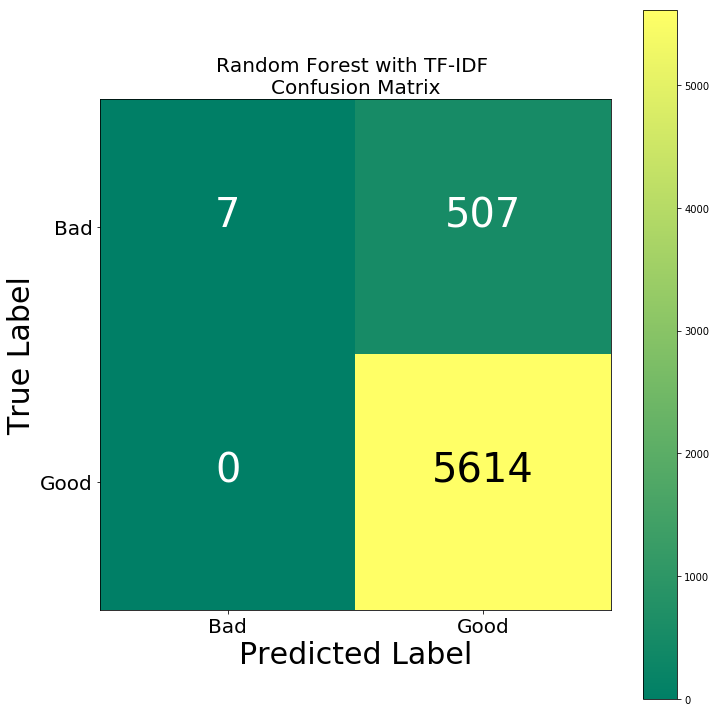

In [48]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

### 4.2.3 Naive Bayes with TF-IDF

In [49]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.8760199155649777


**Classification Report**

In [50]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.46      0.50      0.48      6128
weighted avg       0.84      0.92      0.88      6128



**Confusion Matrix**

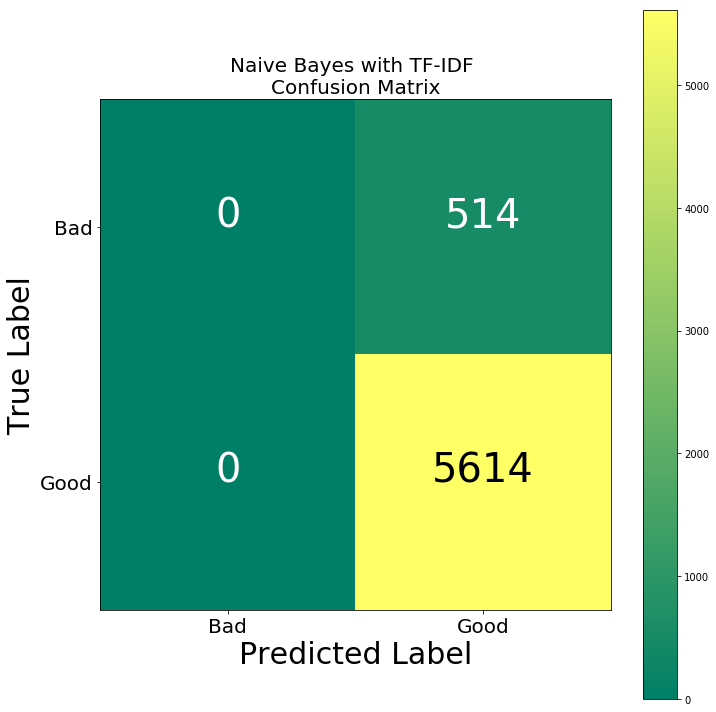

In [51]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

### 4.2.4 XGBoost with TF-IDF

In [52]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

f1 score: 0.8971422869530663


**Classification Report**

In [53]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.76      0.12      0.21       514
           1       0.93      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.84      0.56      0.59      6128
weighted avg       0.91      0.92      0.90      6128



**Confusion Matrix**

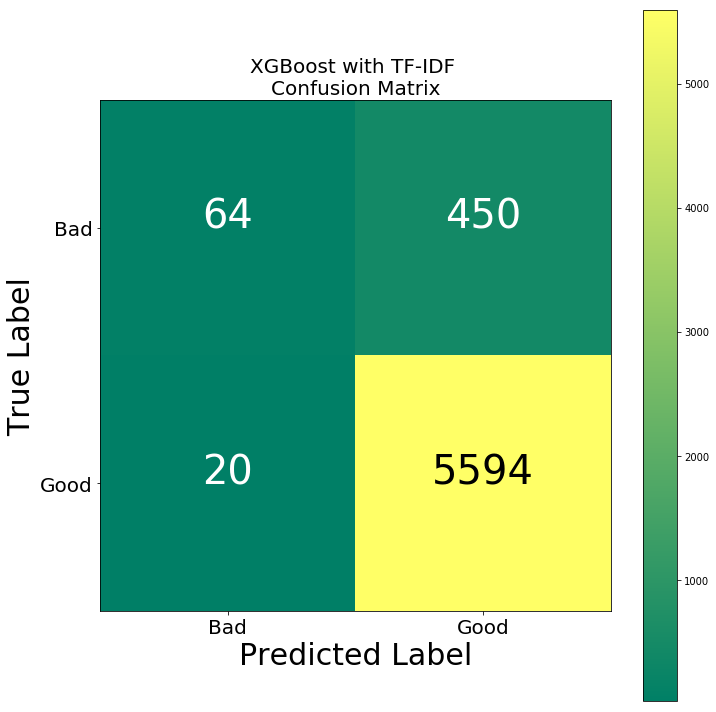

In [54]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

### 4.2.5 Catboost with TF-IDF

In [55]:
# Call the modeling function for Catboost with TF-IDF and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_catboost = y_pred

0:	learn: 0.3016853	total: 116ms	remaining: 2m 53s
1:	learn: 0.2722303	total: 212ms	remaining: 2m 38s
2:	learn: 0.2660376	total: 299ms	remaining: 2m 29s
3:	learn: 0.2576710	total: 387ms	remaining: 2m 24s
4:	learn: 0.2480941	total: 473ms	remaining: 2m 21s
5:	learn: 0.2448914	total: 561ms	remaining: 2m 19s
6:	learn: 0.2379666	total: 647ms	remaining: 2m 18s
7:	learn: 0.2314107	total: 731ms	remaining: 2m 16s
8:	learn: 0.2290738	total: 813ms	remaining: 2m 14s
9:	learn: 0.2262923	total: 919ms	remaining: 2m 16s
10:	learn: 0.2245334	total: 1.03s	remaining: 2m 18s
11:	learn: 0.2226709	total: 1.11s	remaining: 2m 17s
12:	learn: 0.2163520	total: 1.22s	remaining: 2m 19s
13:	learn: 0.2144680	total: 1.32s	remaining: 2m 20s
14:	learn: 0.2106532	total: 1.41s	remaining: 2m 19s
15:	learn: 0.2075915	total: 1.5s	remaining: 2m 19s
16:	learn: 0.2064084	total: 1.58s	remaining: 2m 17s
17:	learn: 0.2029201	total: 1.66s	remaining: 2m 16s
18:	learn: 0.2017956	total: 1.75s	remaining: 2m 16s
19:	learn: 0.2004559	to

159:	learn: 0.1373580	total: 13.6s	remaining: 1m 53s
160:	learn: 0.1371775	total: 13.7s	remaining: 1m 53s
161:	learn: 0.1370965	total: 13.7s	remaining: 1m 53s
162:	learn: 0.1368535	total: 13.8s	remaining: 1m 53s
163:	learn: 0.1366415	total: 13.9s	remaining: 1m 53s
164:	learn: 0.1365408	total: 14s	remaining: 1m 53s
165:	learn: 0.1364659	total: 14.1s	remaining: 1m 53s
166:	learn: 0.1363370	total: 14.1s	remaining: 1m 52s
167:	learn: 0.1361145	total: 14.2s	remaining: 1m 52s
168:	learn: 0.1357721	total: 14.3s	remaining: 1m 52s
169:	learn: 0.1356272	total: 14.4s	remaining: 1m 52s
170:	learn: 0.1354712	total: 14.5s	remaining: 1m 52s
171:	learn: 0.1352240	total: 14.6s	remaining: 1m 52s
172:	learn: 0.1349541	total: 14.7s	remaining: 1m 52s
173:	learn: 0.1348742	total: 14.7s	remaining: 1m 52s
174:	learn: 0.1347375	total: 14.8s	remaining: 1m 52s
175:	learn: 0.1346536	total: 14.9s	remaining: 1m 52s
176:	learn: 0.1344993	total: 15s	remaining: 1m 52s
177:	learn: 0.1343541	total: 15.1s	remaining: 1m 5

315:	learn: 0.1152291	total: 27.4s	remaining: 1m 42s
316:	learn: 0.1149991	total: 27.5s	remaining: 1m 42s
317:	learn: 0.1148664	total: 27.5s	remaining: 1m 42s
318:	learn: 0.1147676	total: 27.6s	remaining: 1m 42s
319:	learn: 0.1147600	total: 27.7s	remaining: 1m 42s
320:	learn: 0.1147109	total: 27.8s	remaining: 1m 41s
321:	learn: 0.1146830	total: 27.8s	remaining: 1m 41s
322:	learn: 0.1144937	total: 27.9s	remaining: 1m 41s
323:	learn: 0.1144589	total: 28s	remaining: 1m 41s
324:	learn: 0.1142463	total: 28.1s	remaining: 1m 41s
325:	learn: 0.1141882	total: 28.1s	remaining: 1m 41s
326:	learn: 0.1141700	total: 28.2s	remaining: 1m 41s
327:	learn: 0.1140899	total: 28.3s	remaining: 1m 41s
328:	learn: 0.1140761	total: 28.4s	remaining: 1m 40s
329:	learn: 0.1140317	total: 28.4s	remaining: 1m 40s
330:	learn: 0.1140061	total: 28.5s	remaining: 1m 40s
331:	learn: 0.1139671	total: 28.6s	remaining: 1m 40s
332:	learn: 0.1139333	total: 28.7s	remaining: 1m 40s
333:	learn: 0.1139304	total: 28.7s	remaining: 1m

471:	learn: 0.1015961	total: 39.2s	remaining: 1m 25s
472:	learn: 0.1015882	total: 39.3s	remaining: 1m 25s
473:	learn: 0.1014990	total: 39.4s	remaining: 1m 25s
474:	learn: 0.1014917	total: 39.5s	remaining: 1m 25s
475:	learn: 0.1013522	total: 39.5s	remaining: 1m 25s
476:	learn: 0.1009711	total: 39.6s	remaining: 1m 24s
477:	learn: 0.1008677	total: 39.7s	remaining: 1m 24s
478:	learn: 0.1007288	total: 39.8s	remaining: 1m 24s
479:	learn: 0.1007233	total: 39.9s	remaining: 1m 24s
480:	learn: 0.1004821	total: 39.9s	remaining: 1m 24s
481:	learn: 0.1003941	total: 40s	remaining: 1m 24s
482:	learn: 0.1003861	total: 40.1s	remaining: 1m 24s
483:	learn: 0.1003797	total: 40.2s	remaining: 1m 24s
484:	learn: 0.1003634	total: 40.2s	remaining: 1m 24s
485:	learn: 0.1003614	total: 40.3s	remaining: 1m 24s
486:	learn: 0.1003140	total: 40.4s	remaining: 1m 24s
487:	learn: 0.1001654	total: 40.5s	remaining: 1m 23s
488:	learn: 0.1001125	total: 40.6s	remaining: 1m 23s
489:	learn: 0.1001086	total: 40.7s	remaining: 1m

627:	learn: 0.0938003	total: 51.9s	remaining: 1m 12s
628:	learn: 0.0937973	total: 52s	remaining: 1m 11s
629:	learn: 0.0937956	total: 52s	remaining: 1m 11s
630:	learn: 0.0937860	total: 52.1s	remaining: 1m 11s
631:	learn: 0.0935729	total: 52.2s	remaining: 1m 11s
632:	learn: 0.0934608	total: 52.3s	remaining: 1m 11s
633:	learn: 0.0932490	total: 52.4s	remaining: 1m 11s
634:	learn: 0.0932488	total: 52.5s	remaining: 1m 11s
635:	learn: 0.0932453	total: 52.5s	remaining: 1m 11s
636:	learn: 0.0932350	total: 52.6s	remaining: 1m 11s
637:	learn: 0.0931644	total: 52.7s	remaining: 1m 11s
638:	learn: 0.0931570	total: 52.8s	remaining: 1m 11s
639:	learn: 0.0931055	total: 52.9s	remaining: 1m 11s
640:	learn: 0.0930760	total: 53s	remaining: 1m 10s
641:	learn: 0.0930737	total: 53s	remaining: 1m 10s
642:	learn: 0.0930170	total: 53.1s	remaining: 1m 10s
643:	learn: 0.0929897	total: 53.2s	remaining: 1m 10s
644:	learn: 0.0928878	total: 53.3s	remaining: 1m 10s
645:	learn: 0.0928603	total: 53.4s	remaining: 1m 10s
6

788:	learn: 0.0880037	total: 1m 6s	remaining: 59.5s
789:	learn: 0.0880036	total: 1m 6s	remaining: 59.4s
790:	learn: 0.0879988	total: 1m 6s	remaining: 59.3s
791:	learn: 0.0879840	total: 1m 6s	remaining: 59.2s
792:	learn: 0.0879469	total: 1m 6s	remaining: 59.2s
793:	learn: 0.0878877	total: 1m 6s	remaining: 59.1s
794:	learn: 0.0878287	total: 1m 6s	remaining: 59s
795:	learn: 0.0878257	total: 1m 6s	remaining: 58.9s
796:	learn: 0.0878226	total: 1m 6s	remaining: 58.8s
797:	learn: 0.0876505	total: 1m 6s	remaining: 58.7s
798:	learn: 0.0875692	total: 1m 6s	remaining: 58.7s
799:	learn: 0.0875683	total: 1m 6s	remaining: 58.6s
800:	learn: 0.0875506	total: 1m 7s	remaining: 58.5s
801:	learn: 0.0873667	total: 1m 7s	remaining: 58.4s
802:	learn: 0.0873530	total: 1m 7s	remaining: 58.3s
803:	learn: 0.0873357	total: 1m 7s	remaining: 58.2s
804:	learn: 0.0873253	total: 1m 7s	remaining: 58.2s
805:	learn: 0.0871888	total: 1m 7s	remaining: 58.1s
806:	learn: 0.0871528	total: 1m 7s	remaining: 58s
807:	learn: 0.08

946:	learn: 0.0805607	total: 1m 19s	remaining: 46.3s
947:	learn: 0.0804064	total: 1m 19s	remaining: 46.3s
948:	learn: 0.0803983	total: 1m 19s	remaining: 46.2s
949:	learn: 0.0803949	total: 1m 19s	remaining: 46.1s
950:	learn: 0.0803939	total: 1m 19s	remaining: 46s
951:	learn: 0.0803864	total: 1m 19s	remaining: 45.9s
952:	learn: 0.0803832	total: 1m 19s	remaining: 45.8s
953:	learn: 0.0803039	total: 1m 19s	remaining: 45.8s
954:	learn: 0.0802462	total: 1m 20s	remaining: 45.7s
955:	learn: 0.0802434	total: 1m 20s	remaining: 45.6s
956:	learn: 0.0801672	total: 1m 20s	remaining: 45.5s
957:	learn: 0.0800871	total: 1m 20s	remaining: 45.4s
958:	learn: 0.0800543	total: 1m 20s	remaining: 45.3s
959:	learn: 0.0800533	total: 1m 20s	remaining: 45.2s
960:	learn: 0.0800489	total: 1m 20s	remaining: 45.1s
961:	learn: 0.0799974	total: 1m 20s	remaining: 45.1s
962:	learn: 0.0799900	total: 1m 20s	remaining: 45s
963:	learn: 0.0799851	total: 1m 20s	remaining: 44.9s
964:	learn: 0.0799848	total: 1m 20s	remaining: 44.

1101:	learn: 0.0762298	total: 1m 31s	remaining: 32.9s
1102:	learn: 0.0757355	total: 1m 31s	remaining: 32.8s
1103:	learn: 0.0757148	total: 1m 31s	remaining: 32.7s
1104:	learn: 0.0756441	total: 1m 31s	remaining: 32.6s
1105:	learn: 0.0756419	total: 1m 31s	remaining: 32.5s
1106:	learn: 0.0756299	total: 1m 31s	remaining: 32.5s
1107:	learn: 0.0756103	total: 1m 31s	remaining: 32.4s
1108:	learn: 0.0755900	total: 1m 31s	remaining: 32.3s
1109:	learn: 0.0755431	total: 1m 31s	remaining: 32.2s
1110:	learn: 0.0755357	total: 1m 31s	remaining: 32.1s
1111:	learn: 0.0755343	total: 1m 31s	remaining: 32s
1112:	learn: 0.0755341	total: 1m 31s	remaining: 31.9s
1113:	learn: 0.0755333	total: 1m 31s	remaining: 31.9s
1114:	learn: 0.0755299	total: 1m 32s	remaining: 31.8s
1115:	learn: 0.0755146	total: 1m 32s	remaining: 31.7s
1116:	learn: 0.0755142	total: 1m 32s	remaining: 31.6s
1117:	learn: 0.0755134	total: 1m 32s	remaining: 31.5s
1118:	learn: 0.0755059	total: 1m 32s	remaining: 31.4s
1119:	learn: 0.0754633	total: 

1256:	learn: 0.0721520	total: 1m 42s	remaining: 19.9s
1257:	learn: 0.0721497	total: 1m 42s	remaining: 19.8s
1258:	learn: 0.0721492	total: 1m 42s	remaining: 19.7s
1259:	learn: 0.0720837	total: 1m 42s	remaining: 19.6s
1260:	learn: 0.0720824	total: 1m 42s	remaining: 19.5s
1261:	learn: 0.0720704	total: 1m 43s	remaining: 19.4s
1262:	learn: 0.0720595	total: 1m 43s	remaining: 19.4s
1263:	learn: 0.0719438	total: 1m 43s	remaining: 19.3s
1264:	learn: 0.0718817	total: 1m 43s	remaining: 19.2s
1265:	learn: 0.0718817	total: 1m 43s	remaining: 19.1s
1266:	learn: 0.0718673	total: 1m 43s	remaining: 19s
1267:	learn: 0.0718513	total: 1m 43s	remaining: 18.9s
1268:	learn: 0.0718510	total: 1m 43s	remaining: 18.9s
1269:	learn: 0.0718425	total: 1m 43s	remaining: 18.8s
1270:	learn: 0.0718425	total: 1m 43s	remaining: 18.7s
1271:	learn: 0.0718424	total: 1m 43s	remaining: 18.6s
1272:	learn: 0.0718326	total: 1m 43s	remaining: 18.5s
1273:	learn: 0.0718316	total: 1m 43s	remaining: 18.4s
1274:	learn: 0.0718131	total: 

1409:	learn: 0.0687799	total: 1m 54s	remaining: 7.29s
1410:	learn: 0.0687712	total: 1m 54s	remaining: 7.21s
1411:	learn: 0.0687622	total: 1m 54s	remaining: 7.12s
1412:	learn: 0.0687597	total: 1m 54s	remaining: 7.04s
1413:	learn: 0.0685621	total: 1m 54s	remaining: 6.96s
1414:	learn: 0.0685529	total: 1m 54s	remaining: 6.88s
1415:	learn: 0.0685477	total: 1m 54s	remaining: 6.8s
1416:	learn: 0.0685219	total: 1m 54s	remaining: 6.72s
1417:	learn: 0.0685217	total: 1m 54s	remaining: 6.63s
1418:	learn: 0.0685070	total: 1m 54s	remaining: 6.55s
1419:	learn: 0.0684618	total: 1m 54s	remaining: 6.47s
1420:	learn: 0.0683904	total: 1m 54s	remaining: 6.39s
1421:	learn: 0.0683617	total: 1m 55s	remaining: 6.31s
1422:	learn: 0.0683606	total: 1m 55s	remaining: 6.23s
1423:	learn: 0.0683554	total: 1m 55s	remaining: 6.15s
1424:	learn: 0.0683327	total: 1m 55s	remaining: 6.07s
1425:	learn: 0.0683031	total: 1m 55s	remaining: 5.99s
1426:	learn: 0.0682216	total: 1m 55s	remaining: 5.91s
1427:	learn: 0.0681661	total:

**Classification Report**

In [56]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_catboost))

              precision    recall  f1-score   support

           0       0.59      0.39      0.47       514
           1       0.95      0.98      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.77      0.68      0.71      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

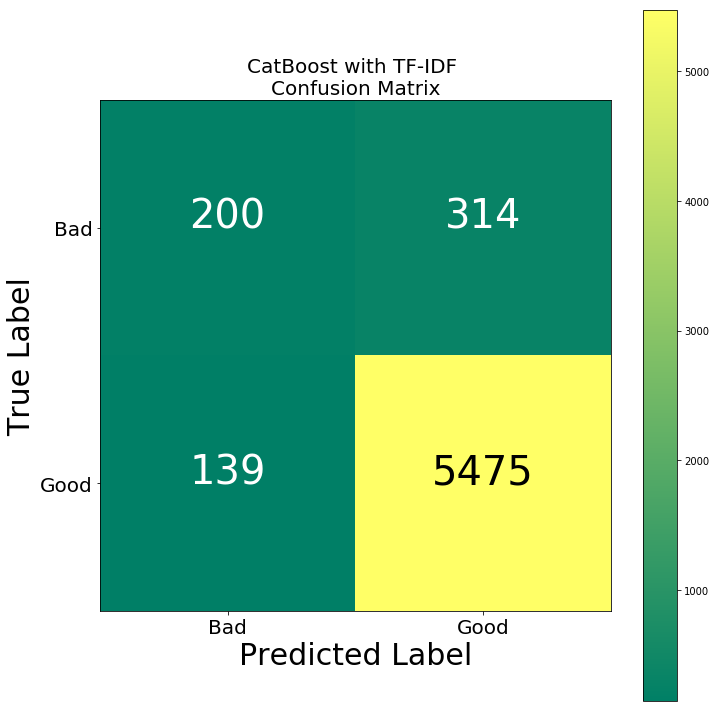

In [57]:
# Print confusion matrix for CatBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_catboost, "CatBoost", "TF-IDF")

### 4.2.6 Comparision of Models with TF-IDF Vectorizer

In [58]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb, y_pred_tfidf_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

**Comparison Table - TF-IDF Vectorizing**

In [59]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.875490 bad       0.388140  0.840467  0.531039   
                                  good      0.983649  0.878696  0.928215   
                                  average   0.933699  0.875490  0.894901   
           Random Forest 0.917265 bad       1.000000  0.013619  0.026871   
                                  good      0.917170  1.000000  0.956796   
                                  average   0.924118  0.917265  0.878796   
           Naive Bayes   0.916123 bad       0.000000  0.000000  0.000000   
                                  good      0.916123  1.000000  0.956226   
                                  average   0.839281  0.916123  0.876020   
           XGBoost       0.923303 bad       0.761905  0.124514  0.214047   
                                  good      0.925546  0.996437  0.959684   
                                  average   0.911820  0.923303  0.897142   
           CatBoost      0.926077 bad       0.589971  0.389105  0.468933   
                                  good      0.945759  0.975240  0.960274   
                                  average   0.915917  0.926077  0.919061   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.875490 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917265 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.916123 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.923303 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.926077 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 score - Models with TF-IDF Vectorizer**

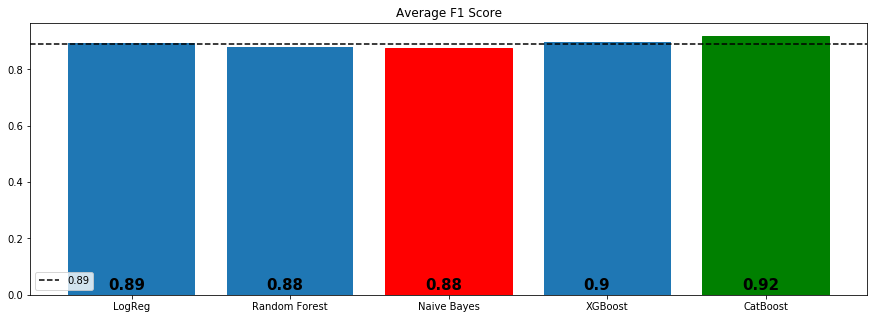

In [60]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 4.3 Hash Vectorizer Bag of Words 

Hash Vectorizer is designed to be as memory efficient as possible. Instead of storing the tokens as strings, the vectorizer applies the hashing trick to encode them as numerical indexes. The downside of this method is that once vectorized, the features’ names can no longer be retrieved.

In [84]:
# Create the word vector with Hash Vectorizer
hash_vect = HashingVectorizer(n_features=2000, ngram_range=(1,1), non_negative=True)
hash_vect_train = hash_vect.fit_transform(X_train)
hash_vect_train = hash_vect_train.toarray()
hash_vect_test = hash_vect.transform(X_test)
hash_vect_test = hash_vect_test.toarray()

### 4.3.1 Logistic Regression with Hash Vectorizer

In [62]:
# Call the modeling function for logistic regression with Hash Vectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_logreg = y_pred

f1 score: 0.8624781332189204


**Classification Report**

In [63]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_logreg))

              precision    recall  f1-score   support

           0       0.31      0.82      0.45       514
           1       0.98      0.83      0.90      5614

   micro avg       0.83      0.83      0.83      6128
   macro avg       0.64      0.82      0.67      6128
weighted avg       0.92      0.83      0.86      6128



**Confusion Matrix**

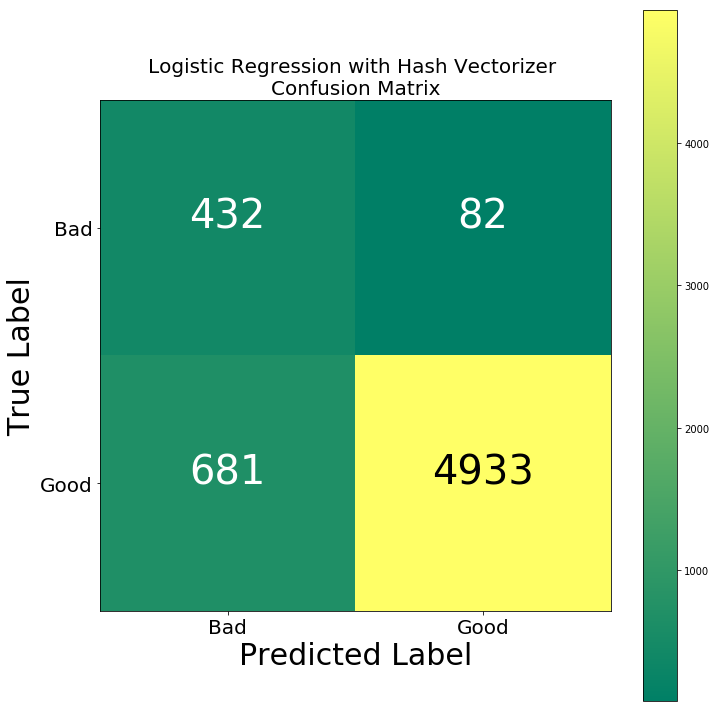

In [64]:
# Print confusion matrix for logistic regression with Hash Vectorizer
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "Hash Vectorizer")

### 4.3.2 Random Forest with Hash Vectorizer

In [90]:
# Call the modeling function for random forest classifier with Hash Vectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_rf = y_pred

f1 score: 0.8787963670186205


**Classification Report**

In [91]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_rf))

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

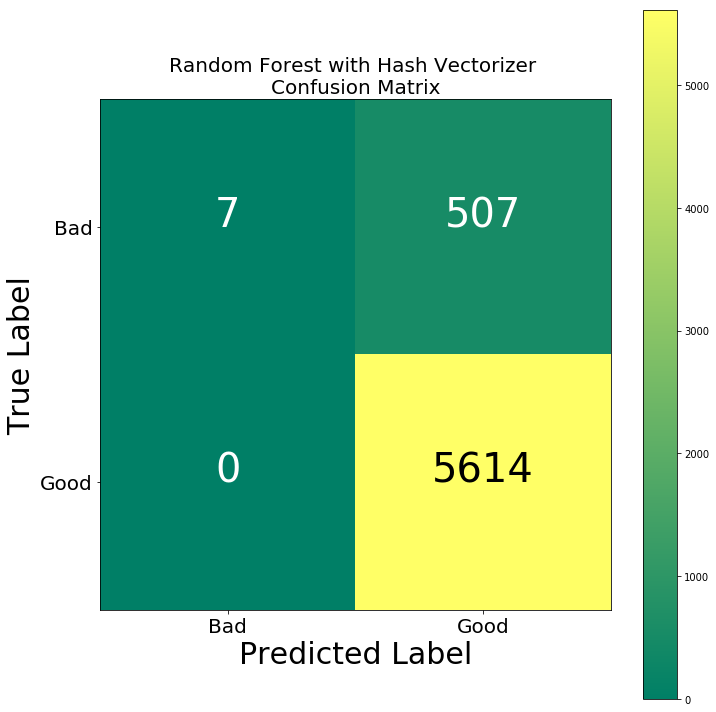

In [67]:
# Print confusion matrix for random forest classifier with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_rf, "Random Forest", "Hash Vectorizer")

### 4.3.3 Naive Bayes with Hash Vectorizer

In [86]:
# Call the modeling function for naive bayes with Hash Vectorizer and print f1 score
modeling(MultinomialNB(), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_nb = y_pred

f1 score: 0.8761740049132273


**Classification Report**

In [87]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_nb))

              precision    recall  f1-score   support

           0       0.25      0.00      0.00       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.58      0.50      0.48      6128
weighted avg       0.86      0.92      0.88      6128



**Confusion Matrix**

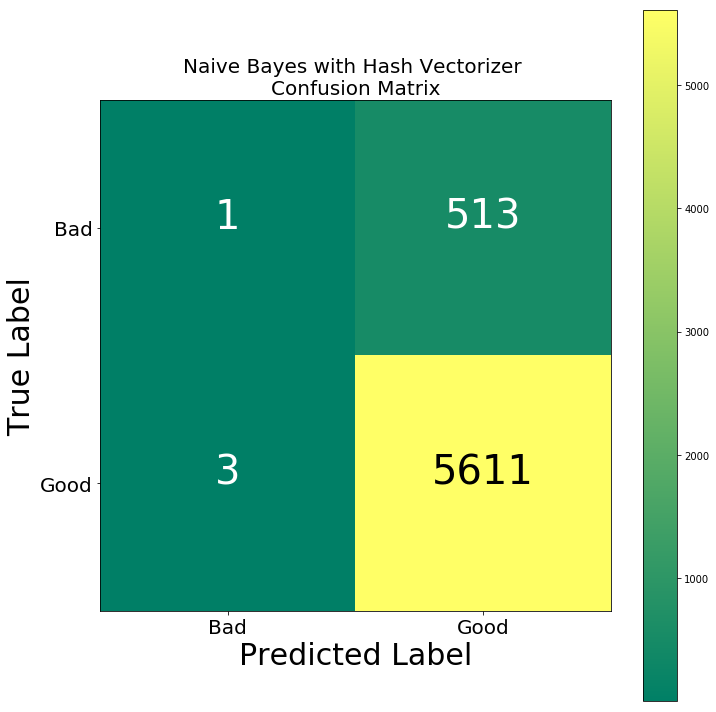

In [88]:
# Print confusion matrix for naive bayes with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_nb, "Naive Bayes", "Hash Vectorizer")

### 4.3.4 XGBoost with Hash Vectorizer

In [89]:
# Call the modeling function for XGBoost with Hash Vectorizer and print f1 score
modeling(XGBClassifier(), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_xgb = y_pred

f1 score: 0.8942279470073832


**Classification Report**

In [73]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_xgb))

              precision    recall  f1-score   support

           0       0.79      0.12      0.21       514
           1       0.93      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.86      0.56      0.58      6128
weighted avg       0.91      0.92      0.90      6128



**Confusion Matrix**

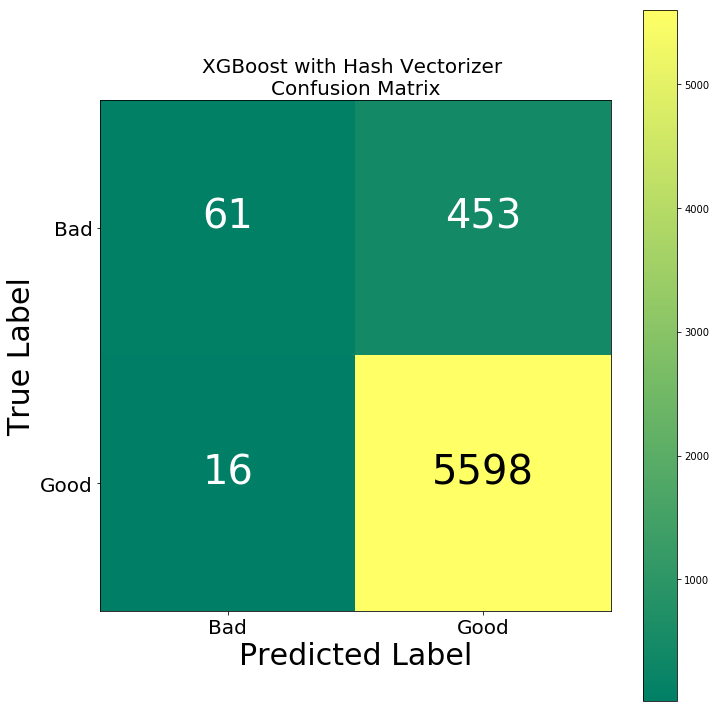

In [77]:
# Print confusion matrix for XGBoost with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_xgb, "XGBoost", "Hash Vectorizer")

### 4.3.5 CatBoost with Hash Vectorizer

In [78]:
# Call the modeling function for Catboost with Hash Vectorizer and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_catboost = y_pred

0:	learn: 0.3017681	total: 152ms	remaining: 3m 48s
1:	learn: 0.2700947	total: 273ms	remaining: 3m 24s
2:	learn: 0.2587396	total: 381ms	remaining: 3m 9s
3:	learn: 0.2506643	total: 492ms	remaining: 3m 4s
4:	learn: 0.2471602	total: 626ms	remaining: 3m 7s
5:	learn: 0.2433708	total: 749ms	remaining: 3m 6s
6:	learn: 0.2404667	total: 863ms	remaining: 3m 4s
7:	learn: 0.2324405	total: 995ms	remaining: 3m 5s
8:	learn: 0.2285126	total: 1.13s	remaining: 3m 7s
9:	learn: 0.2259383	total: 1.26s	remaining: 3m 7s
10:	learn: 0.2217318	total: 1.38s	remaining: 3m 6s
11:	learn: 0.2213050	total: 1.49s	remaining: 3m 5s
12:	learn: 0.2177395	total: 1.61s	remaining: 3m 4s
13:	learn: 0.2165634	total: 1.71s	remaining: 3m 1s
14:	learn: 0.2150981	total: 1.84s	remaining: 3m 1s
15:	learn: 0.2122108	total: 1.95s	remaining: 3m
16:	learn: 0.2108620	total: 2.06s	remaining: 2m 59s
17:	learn: 0.2099944	total: 2.16s	remaining: 2m 58s
18:	learn: 0.2091302	total: 2.27s	remaining: 2m 56s
19:	learn: 0.2085267	total: 2.38s	remai

158:	learn: 0.1435236	total: 17.6s	remaining: 2m 28s
159:	learn: 0.1432533	total: 17.7s	remaining: 2m 28s
160:	learn: 0.1430640	total: 17.8s	remaining: 2m 28s
161:	learn: 0.1428947	total: 17.9s	remaining: 2m 28s
162:	learn: 0.1427699	total: 18s	remaining: 2m 27s
163:	learn: 0.1426569	total: 18.1s	remaining: 2m 27s
164:	learn: 0.1426021	total: 18.2s	remaining: 2m 27s
165:	learn: 0.1424137	total: 18.3s	remaining: 2m 27s
166:	learn: 0.1422354	total: 18.4s	remaining: 2m 26s
167:	learn: 0.1420686	total: 18.5s	remaining: 2m 26s
168:	learn: 0.1419839	total: 18.6s	remaining: 2m 26s
169:	learn: 0.1417849	total: 18.7s	remaining: 2m 26s
170:	learn: 0.1417772	total: 18.8s	remaining: 2m 26s
171:	learn: 0.1416088	total: 18.9s	remaining: 2m 26s
172:	learn: 0.1409883	total: 19s	remaining: 2m 25s
173:	learn: 0.1406043	total: 19.1s	remaining: 2m 25s
174:	learn: 0.1404074	total: 19.2s	remaining: 2m 25s
175:	learn: 0.1394992	total: 19.3s	remaining: 2m 25s
176:	learn: 0.1394060	total: 19.4s	remaining: 2m 2

315:	learn: 0.1223681	total: 33.8s	remaining: 2m 6s
316:	learn: 0.1223645	total: 33.9s	remaining: 2m 6s
317:	learn: 0.1222604	total: 34s	remaining: 2m 6s
318:	learn: 0.1219903	total: 34.1s	remaining: 2m 6s
319:	learn: 0.1219632	total: 34.2s	remaining: 2m 6s
320:	learn: 0.1219586	total: 34.3s	remaining: 2m 5s
321:	learn: 0.1219138	total: 34.4s	remaining: 2m 5s
322:	learn: 0.1216965	total: 34.5s	remaining: 2m 5s
323:	learn: 0.1216909	total: 34.6s	remaining: 2m 5s
324:	learn: 0.1216587	total: 34.7s	remaining: 2m 5s
325:	learn: 0.1216049	total: 34.8s	remaining: 2m 5s
326:	learn: 0.1214496	total: 34.9s	remaining: 2m 5s
327:	learn: 0.1214335	total: 35s	remaining: 2m 5s
328:	learn: 0.1213842	total: 35.1s	remaining: 2m 4s
329:	learn: 0.1213842	total: 35.2s	remaining: 2m 4s
330:	learn: 0.1213709	total: 35.3s	remaining: 2m 4s
331:	learn: 0.1212590	total: 35.4s	remaining: 2m 4s
332:	learn: 0.1211462	total: 35.5s	remaining: 2m 4s
333:	learn: 0.1209807	total: 35.6s	remaining: 2m 4s
334:	learn: 0.12

473:	learn: 0.1104893	total: 49.2s	remaining: 1m 46s
474:	learn: 0.1104746	total: 49.3s	remaining: 1m 46s
475:	learn: 0.1101182	total: 49.4s	remaining: 1m 46s
476:	learn: 0.1100928	total: 49.5s	remaining: 1m 46s
477:	learn: 0.1100446	total: 49.6s	remaining: 1m 46s
478:	learn: 0.1095178	total: 49.7s	remaining: 1m 45s
479:	learn: 0.1094973	total: 49.8s	remaining: 1m 45s
480:	learn: 0.1093446	total: 49.9s	remaining: 1m 45s
481:	learn: 0.1093419	total: 50s	remaining: 1m 45s
482:	learn: 0.1093413	total: 50.1s	remaining: 1m 45s
483:	learn: 0.1093280	total: 50.2s	remaining: 1m 45s
484:	learn: 0.1093152	total: 50.3s	remaining: 1m 45s
485:	learn: 0.1089673	total: 50.4s	remaining: 1m 45s
486:	learn: 0.1089425	total: 50.5s	remaining: 1m 44s
487:	learn: 0.1089108	total: 50.6s	remaining: 1m 44s
488:	learn: 0.1089032	total: 50.7s	remaining: 1m 44s
489:	learn: 0.1087444	total: 50.8s	remaining: 1m 44s
490:	learn: 0.1085273	total: 50.9s	remaining: 1m 44s
491:	learn: 0.1083210	total: 50.9s	remaining: 1m

631:	learn: 0.0997634	total: 1m 4s	remaining: 1m 28s
632:	learn: 0.0997578	total: 1m 4s	remaining: 1m 28s
633:	learn: 0.0996911	total: 1m 4s	remaining: 1m 28s
634:	learn: 0.0996729	total: 1m 5s	remaining: 1m 28s
635:	learn: 0.0995903	total: 1m 5s	remaining: 1m 28s
636:	learn: 0.0995605	total: 1m 5s	remaining: 1m 28s
637:	learn: 0.0994238	total: 1m 5s	remaining: 1m 28s
638:	learn: 0.0993878	total: 1m 5s	remaining: 1m 28s
639:	learn: 0.0993564	total: 1m 5s	remaining: 1m 28s
640:	learn: 0.0992967	total: 1m 5s	remaining: 1m 27s
641:	learn: 0.0992916	total: 1m 5s	remaining: 1m 27s
642:	learn: 0.0992747	total: 1m 5s	remaining: 1m 27s
643:	learn: 0.0992492	total: 1m 5s	remaining: 1m 27s
644:	learn: 0.0991631	total: 1m 6s	remaining: 1m 27s
645:	learn: 0.0991288	total: 1m 6s	remaining: 1m 27s
646:	learn: 0.0989834	total: 1m 6s	remaining: 1m 27s
647:	learn: 0.0989819	total: 1m 6s	remaining: 1m 27s
648:	learn: 0.0989605	total: 1m 6s	remaining: 1m 27s
649:	learn: 0.0988506	total: 1m 6s	remaining: 

786:	learn: 0.0944979	total: 1m 19s	remaining: 1m 12s
787:	learn: 0.0944912	total: 1m 20s	remaining: 1m 12s
788:	learn: 0.0944899	total: 1m 20s	remaining: 1m 12s
789:	learn: 0.0944860	total: 1m 20s	remaining: 1m 12s
790:	learn: 0.0943998	total: 1m 20s	remaining: 1m 12s
791:	learn: 0.0943280	total: 1m 20s	remaining: 1m 11s
792:	learn: 0.0942778	total: 1m 20s	remaining: 1m 11s
793:	learn: 0.0942677	total: 1m 20s	remaining: 1m 11s
794:	learn: 0.0942646	total: 1m 20s	remaining: 1m 11s
795:	learn: 0.0942191	total: 1m 20s	remaining: 1m 11s
796:	learn: 0.0942042	total: 1m 20s	remaining: 1m 11s
797:	learn: 0.0942009	total: 1m 20s	remaining: 1m 11s
798:	learn: 0.0941967	total: 1m 21s	remaining: 1m 11s
799:	learn: 0.0941964	total: 1m 21s	remaining: 1m 11s
800:	learn: 0.0941780	total: 1m 21s	remaining: 1m 10s
801:	learn: 0.0941693	total: 1m 21s	remaining: 1m 10s
802:	learn: 0.0941319	total: 1m 21s	remaining: 1m 10s
803:	learn: 0.0941265	total: 1m 21s	remaining: 1m 10s
804:	learn: 0.0940182	total:

941:	learn: 0.0882629	total: 1m 35s	remaining: 56.3s
942:	learn: 0.0882611	total: 1m 35s	remaining: 56.2s
943:	learn: 0.0882598	total: 1m 35s	remaining: 56.1s
944:	learn: 0.0882527	total: 1m 35s	remaining: 56s
945:	learn: 0.0882451	total: 1m 35s	remaining: 55.9s
946:	learn: 0.0882407	total: 1m 35s	remaining: 55.8s
947:	learn: 0.0882322	total: 1m 35s	remaining: 55.7s
948:	learn: 0.0882311	total: 1m 35s	remaining: 55.6s
949:	learn: 0.0882304	total: 1m 35s	remaining: 55.5s
950:	learn: 0.0881365	total: 1m 35s	remaining: 55.3s
951:	learn: 0.0881362	total: 1m 35s	remaining: 55.2s
952:	learn: 0.0881349	total: 1m 36s	remaining: 55.1s
953:	learn: 0.0881295	total: 1m 36s	remaining: 55s
954:	learn: 0.0881295	total: 1m 36s	remaining: 54.9s
955:	learn: 0.0881287	total: 1m 36s	remaining: 54.8s
956:	learn: 0.0881277	total: 1m 36s	remaining: 54.7s
957:	learn: 0.0880846	total: 1m 36s	remaining: 54.6s
958:	learn: 0.0880845	total: 1m 36s	remaining: 54.5s
959:	learn: 0.0880720	total: 1m 36s	remaining: 54.

1095:	learn: 0.0839571	total: 1m 49s	remaining: 40.5s
1096:	learn: 0.0839545	total: 1m 49s	remaining: 40.3s
1097:	learn: 0.0839501	total: 1m 49s	remaining: 40.2s
1098:	learn: 0.0839104	total: 1m 50s	remaining: 40.1s
1099:	learn: 0.0838650	total: 1m 50s	remaining: 40s
1100:	learn: 0.0838233	total: 1m 50s	remaining: 39.9s
1101:	learn: 0.0838154	total: 1m 50s	remaining: 39.8s
1102:	learn: 0.0838139	total: 1m 50s	remaining: 39.7s
1103:	learn: 0.0838109	total: 1m 50s	remaining: 39.6s
1104:	learn: 0.0837863	total: 1m 50s	remaining: 39.5s
1105:	learn: 0.0837850	total: 1m 50s	remaining: 39.4s
1106:	learn: 0.0837286	total: 1m 50s	remaining: 39.3s
1107:	learn: 0.0837275	total: 1m 50s	remaining: 39.2s
1108:	learn: 0.0836443	total: 1m 50s	remaining: 39.1s
1109:	learn: 0.0836431	total: 1m 51s	remaining: 39s
1110:	learn: 0.0836353	total: 1m 51s	remaining: 38.9s
1111:	learn: 0.0836252	total: 1m 51s	remaining: 38.8s
1112:	learn: 0.0836199	total: 1m 51s	remaining: 38.7s
1113:	learn: 0.0836189	total: 1m

1249:	learn: 0.0808258	total: 2m 5s	remaining: 25s
1250:	learn: 0.0808256	total: 2m 5s	remaining: 24.9s
1251:	learn: 0.0808248	total: 2m 5s	remaining: 24.8s
1252:	learn: 0.0808184	total: 2m 5s	remaining: 24.7s
1253:	learn: 0.0808000	total: 2m 5s	remaining: 24.6s
1254:	learn: 0.0805898	total: 2m 5s	remaining: 24.5s
1255:	learn: 0.0805842	total: 2m 5s	remaining: 24.4s
1256:	learn: 0.0805841	total: 2m 5s	remaining: 24.3s
1257:	learn: 0.0805645	total: 2m 5s	remaining: 24.2s
1258:	learn: 0.0805645	total: 2m 6s	remaining: 24.1s
1259:	learn: 0.0805497	total: 2m 6s	remaining: 24s
1260:	learn: 0.0805497	total: 2m 6s	remaining: 23.9s
1261:	learn: 0.0805411	total: 2m 6s	remaining: 23.8s
1262:	learn: 0.0805410	total: 2m 6s	remaining: 23.7s
1263:	learn: 0.0805395	total: 2m 6s	remaining: 23.6s
1264:	learn: 0.0805335	total: 2m 6s	remaining: 23.5s
1265:	learn: 0.0805332	total: 2m 6s	remaining: 23.4s
1266:	learn: 0.0803122	total: 2m 6s	remaining: 23.3s
1267:	learn: 0.0803102	total: 2m 6s	remaining: 23.

1405:	learn: 0.0778540	total: 2m 19s	remaining: 9.35s
1406:	learn: 0.0778493	total: 2m 20s	remaining: 9.25s
1407:	learn: 0.0778486	total: 2m 20s	remaining: 9.15s
1408:	learn: 0.0778482	total: 2m 20s	remaining: 9.05s
1409:	learn: 0.0775497	total: 2m 20s	remaining: 8.95s
1410:	learn: 0.0775494	total: 2m 20s	remaining: 8.85s
1411:	learn: 0.0775492	total: 2m 20s	remaining: 8.75s
1412:	learn: 0.0775484	total: 2m 20s	remaining: 8.65s
1413:	learn: 0.0775475	total: 2m 20s	remaining: 8.55s
1414:	learn: 0.0775442	total: 2m 20s	remaining: 8.46s
1415:	learn: 0.0775440	total: 2m 20s	remaining: 8.36s
1416:	learn: 0.0774265	total: 2m 20s	remaining: 8.26s
1417:	learn: 0.0773254	total: 2m 21s	remaining: 8.16s
1418:	learn: 0.0773248	total: 2m 21s	remaining: 8.06s
1419:	learn: 0.0773230	total: 2m 21s	remaining: 7.96s
1420:	learn: 0.0773228	total: 2m 21s	remaining: 7.86s
1421:	learn: 0.0773190	total: 2m 21s	remaining: 7.76s
1422:	learn: 0.0773178	total: 2m 21s	remaining: 7.66s
1423:	learn: 0.0773176	total

**Classification Report**

In [79]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_catboost))

              precision    recall  f1-score   support

           0       0.57      0.36      0.44       514
           1       0.94      0.97      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.75      0.67      0.70      6128
weighted avg       0.91      0.92      0.92      6128



**Confusion Matrix**

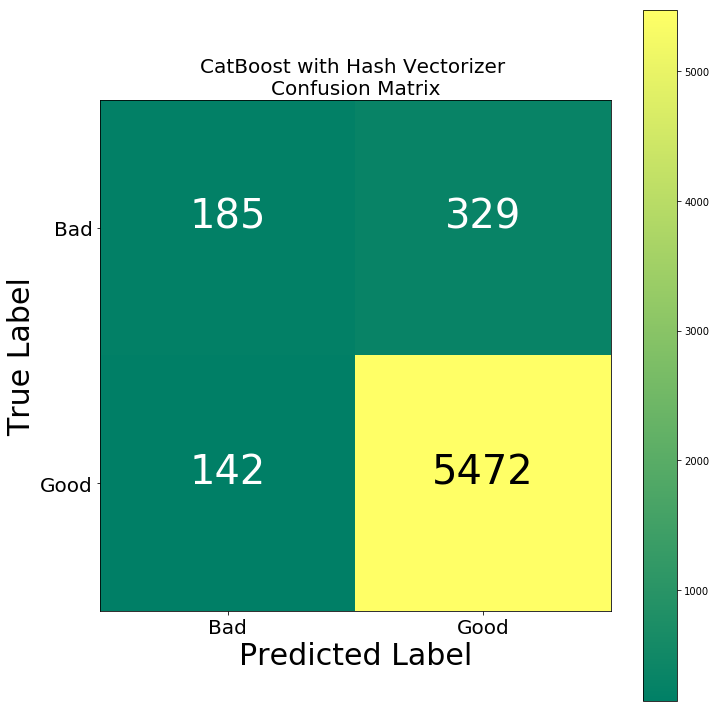

In [80]:
# Print confusion matrix for CatBoost with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_catboost, "CatBoost", "Hash Vectorizer")

### 4.3.6 Comparison of Models with Hash Vectorizer

In [81]:
comparison_table(y_preds = [y_pred_hash_logreg, y_pred_hash_rf, y_pred_hash_nb, y_pred_hash_xgb, y_pred_hash_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

**Comparison Table**

In [82]:
# Print the comparision matrix
print('\nComparision Matrix of Models with Hash Vectorizer\n')
df_tv2


Comparision Matrix of Models with Hash Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.831266 bad       0.308824  0.817121  0.448239   
                                  good      0.980285  0.832561  0.900405   
                                  average   0.923965  0.831266  0.862478   
           Random Forest 0.917265 bad       1.000000  0.013619  0.026871   
                                  good      0.917170  1.000000  0.956796   
                                  average   0.924118  0.917265  0.878796   
           XGBoost       0.923466 bad       0.792208  0.118677  0.206430   
                                  good      0.925136  0.997150  0.959794   
                                  average   0.913987  0.923466  0.896604   
           CatBoost      0.923140 bad       0.565749  0.359922  0.439952   
                                  good      0.943286  0.974706  0.958739   
                                  average   0.911619  0.923140  0.915224   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.831266 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917265 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.923466 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.923140 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 score - Hash Vectorizer**

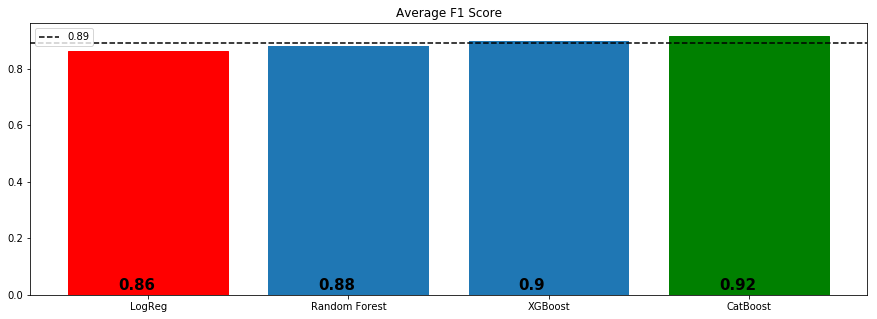

In [83]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")